
# Basic Segment EDA — Dummy Credit Files

**Goal:** Read each CSV in `Data_Dummy/`, split *in memory* into four segment datasets, and show quick info and totals per segment.  
No files are generated unless you set `SAVE_OUTPUT = True`.


In [38]:

from pathlib import Path
import re
import numpy as np
import pandas as pd

# ---------- CONFIG ----------
INPUT_DIR = Path("Data_Dummy")
ENCODING = "latin-1"
NA_VALUES = ["", "NA", "N/A", None]
SAVE_OUTPUT = False  # set True if you later want CSVs per segment
OUTPUT_DIR = Path("output_segmentos")  # used only when SAVE_OUTPUT=True

# Segment dictionary
SEGMENTS = {
    1: "Créditos empresariales",
    2: "Créditos productivos",
    3: "Créditos hipotecarios para vivienda y cédulas hipotecarias",
    4: "Créditos de consumo",
}


In [40]:

def find_segment_columns(df: pd.DataFrame):
    """Return plausible (id_col, text_col) for segment detection."""
    cols = {c.lower(): c for c in df.columns}
    id_candidates = [k for k in cols if any(x in k for x in [
        "segmento_id","segment_id","id_segmento","idsegmento","segmentoid","segmento","segment"
    ])]
    # prefer id-like names first
    id_like = [k for k in id_candidates if "id" in k]
    id_col = cols[id_like[0]] if id_like else None

    # text candidates excluding chosen id
    text_candidates = [k for k in cols if any(x in k for x in [
        "segmento","segment","descripcion","descripción","tipo_credito","tipo_deuda"
    ])]
    if id_col:
        text_candidates = [k for k in text_candidates if cols[k] != id_col]
    text_col = cols[text_candidates[0]] if text_candidates else None
    return id_col, text_col


def normalize_segment(df: pd.DataFrame) -> pd.DataFrame:
    """Create `segment_id` (1..4) and `segment_desc` from id or text."""
    id_col, text_col = find_segment_columns(df)

    text_patterns = [
        (1, re.compile(r"empresarial", re.I)),
        (2, re.compile(r"productiv", re.I)),
        (3, re.compile(r"hipotec", re.I)),
        (4, re.compile(r"consum", re.I)),
    ]

    if id_col is not None and df[id_col].notna().any():
        seg_id = pd.to_numeric(df[id_col], errors="coerce").astype("Int64")
    elif text_col is not None and df[text_col].notna().any():
        def map_text_to_id(x):
            if pd.isna(x): return pd.NA
            s = str(x)
            for sid, pat in text_patterns:
                if pat.search(s): return sid
            return pd.NA
        seg_id = df[text_col].map(map_text_to_id).astype("Int64")
    else:
        seg_id = pd.Series([pd.NA] * len(df), index=df.index, dtype="Int64")

    out = df.copy()
    out["segment_id"] = seg_id
    out["segment_desc"] = out["segment_id"].map(lambda k: SEGMENTS.get(int(k)) if pd.notna(k) else pd.NA)
    return out


In [41]:

# List available CSVs
assert INPUT_DIR.exists(), f"Input folder not found: {INPUT_DIR.resolve()}"
csv_files = sorted(INPUT_DIR.glob("*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No .csv files found in {INPUT_DIR.resolve()}")
csv_files


[WindowsPath('Data_Dummy/JAN24.csv'),
 WindowsPath('Data_Dummy/JAN25.csv'),
 WindowsPath('Data_Dummy/JUN24.csv'),
 WindowsPath('Data_Dummy/MAR24.csv'),
 WindowsPath('Data_Dummy/MAR25.csv')]

In [42]:
# ==== Resumen por archivo y segmento: total datos, total subsegmentos, saldo total ====

def _pick_column(df, candidates, numeric=False):
    """Devuelve el nombre real de la primera columna candidata que exista."""
    cols_map = {c.lower(): c for c in df.columns}
    for name in candidates:
        if name in cols_map:
            col = cols_map[name]
            if not numeric:
                return col
            # si debe ser numérica, intentamos convertir y validamos
            s = pd.to_numeric(df[col], errors="coerce")
            if s.notna().any():
                df[col] = s  # normaliza en el DF original
                return col
    # búsqueda flexible por substring si no hubo match exacto
    for c in df.columns:
        if any(k in c.lower() for k in candidates):
            if not numeric:
                return c
            s = pd.to_numeric(df[c], errors="coerce")
            if s.notna().any():
                df[c] = s
                return c
    return None

rollup_rows = []  # salida final

for path in csv_files:
    print(f"\n===== {path.name} =====")
    df = pd.read_csv(path, encoding=ENCODING, na_values=NA_VALUES, low_memory=False)
    df = normalize_segment(df)

    # Detecta columnas de subsegmento y saldo (ajusta candidatos si tus nombres difieren)
    subseg_col = _pick_column(df, [
        "subsegmento","sub_segmento","subsegment","subtipo","sub_tipo",
        "sub_deuda","subdeuda","subproducto","sub_producto",
        "subtipo_producto","sub_tipo_producto"
    ], numeric=False)

    saldo_col = _pick_column(df, [
        "saldo","saldo_total","monto","monto_total","balance","importe","amount","capital"
    ], numeric=True)

    for sid, sname in SEGMENTS.items():
        seg_df = df[df["segment_id"] == sid]
        total_datos = int(len(seg_df))
        total_subsegmentos = (
            int(seg_df[subseg_col].nunique(dropna=True)) if subseg_col else 0
        )
        saldo_total = (
            float(seg_df[saldo_col].sum()) if (saldo_col and not seg_df.empty) else 0.0
        )

        rollup_rows.append({
            "file": path.name,
            "segmento": sid,
            "segmento_desc": sname,
            "total_datos": total_datos,
            "total_subsegmentos": total_subsegmentos,
            "saldo_total": saldo_total
        })

# DataFrame final con el resumen pedido
rollup_df = pd.DataFrame(rollup_rows).sort_values(["file","segmento"]).reset_index(drop=True)
display(rollup_df)

# Impresión con el formato solicitado
for fname, g in rollup_df.groupby("file"):
    print(f"\n----- {fname} -----")
    for _, r in g.iterrows():
        print(f"{r['segmento']}: total datos={r['total_datos']:,}, "
              f"total subsegmentos={r['total_subsegmentos']}, "
              f"saldo total={r['saldo_total']:,.2f}")



===== JAN24.csv =====

===== JAN25.csv =====

===== JUN24.csv =====

===== MAR24.csv =====

===== MAR25.csv =====


,file,segmento,segmento_desc,total_datos,total_subsegmentos,saldo_total
0,JAN24.csv,1,Créditos empresariales,5243,7,7.988892e+09
1,JAN24.csv,2,Créditos productivos,8040,2,8.450448e+08
2,JAN24.csv,3,Créditos hipotecarios para vivienda y cédulas ...,2126,1,8.425920e+08
3,JAN24.csv,4,Créditos de consumo,384591,2,5.277246e+09
4,JAN25.csv,1,Créditos empresariales,12239,7,2.962451e+10
5,JAN25.csv,2,Créditos productivos,18834,2,1.393053e+09
6,JAN25.csv,3,Créditos hipotecarios para vivienda y cédulas ...,6872,2,1.116354e+09
7,JAN25.csv,4,Créditos de consumo,362055,3,7.411579e+09
8,JUN24.csv,1,Créditos empresariales,88,6,3.415324e+09
9,JUN24.csv,2,Créditos productivos,4,2,2.402127e+08



----- JAN24.csv -----
1: total datos=5,243, total subsegmentos=7, saldo total=7,988,891,865.78
2: total datos=8,040, total subsegmentos=2, saldo total=845,044,821.89
3: total datos=2,126, total subsegmentos=1, saldo total=842,592,015.79
4: total datos=384,591, total subsegmentos=2, saldo total=5,277,246,273.35

----- JAN25.csv -----
1: total datos=12,239, total subsegmentos=7, saldo total=29,624,512,343.11
2: total datos=18,834, total subsegmentos=2, saldo total=1,393,052,955.82
3: total datos=6,872, total subsegmentos=2, saldo total=1,116,353,714.99
4: total datos=362,055, total subsegmentos=3, saldo total=7,411,579,211.84

----- JUN24.csv -----
1: total datos=88, total subsegmentos=6, saldo total=3,415,323,974.78
2: total datos=4, total subsegmentos=2, saldo total=240,212,659.50
3: total datos=0, total subsegmentos=0, saldo total=0.00
4: total datos=9, total subsegmentos=2, saldo total=5,789,079.19

----- MAR24.csv -----
1: total datos=68, total subsegmentos=6, saldo total=2,001,338

In [44]:

if numeric_summary_rows:
    numeric_totals = pd.DataFrame(numeric_summary_rows)
    # Pivot (optional): total_sum per file/segment/column
    pivot_totals = numeric_totals.pivot_table(index=["file","segment_id","segment_desc"],
                                              columns="column",
                                              values="total_sum",
                                              aggfunc="sum").reset_index()
    display(pivot_totals.head(20))
else:
    print("No numeric columns found to totalize.")


column,file,segment_id,segment_desc,id_segmento,id_situacion,id_subsegmento,id_tipo_deudor,saldo,score
0,MAR24.csv,1,Créditos empresariales,68.0,6.800000e+01,899.0,204.0,2.001338e+09,81.0
1,MAR24.csv,2,Créditos productivos,26.0,6.100000e+01,277.0,13.0,1.330536e+08,13.0
2,MAR24.csv,3,Créditos hipotecarios para vivienda y cédulas ...,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
3,MAR24.csv,4,Créditos de consumo,80.0,2.000000e+01,828.0,21.0,3.359208e+06,34.0
4,MAR25.csv,1,Créditos empresariales,68.0,6.800000e+01,899.0,204.0,2.001338e+09,81.0
5,MAR25.csv,2,Créditos productivos,26.0,6.100000e+01,277.0,13.0,1.330536e+08,13.0
6,MAR25.csv,3,Créditos hipotecarios para vivienda y cédulas ...,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0
7,MAR25.csv,4,Créditos de consumo,80.0,2.000000e+01,828.0,21.0,3.359208e+06,34.0
8,SEP24.csv,1,Créditos empresariales,5859.0,5.859000e+03,77146.0,17611.0,3.510150e+10,7176.0
9,SEP24.csv,2,Créditos productivos,214776.0,1.073880e+05,2317666.0,107393.0,1.067175e+10,129485.0



## DATASETS

### JAN 24


In [45]:
from pathlib import Path
import pandas as pd
from io import StringIO

# ---------------- CONFIG ----------------
CSV_PATH = Path("Data_Dummy/JAN24.csv")   # cámbialo por Data_Dummy/jan25.csv u otro
ENCODINGS = ["utf-8", "latin-1"]          # intentos de decodificación
SEGMENTS = {
    1: "Créditos empresariales",
    2: "Créditos productivos",
    3: "Créditos hipotecarios para vivienda y cédulas hipotecarias",
    4: "Créditos de consumo",
}

# --------- carga robusta (un solo dataset por archivo) ---------
assert CSV_PATH.exists(), f"No se encontró: {CSV_PATH.resolve()}"
for enc in ENCODINGS:
    try:
        dataset = pd.read_csv(CSV_PATH, encoding=enc, low_memory=False)
        break
    except UnicodeDecodeError:
        continue

# --------- df.info() ---------
buf = StringIO()
dataset.info(buf=buf)
print(f"Archivo: {CSV_PATH.name} | Filas: {len(dataset):,} | Columnas: {dataset.shape[1]}")
print(buf.getvalue())

# --------- resumen por segmento (si existen columnas) ---------
def _has(cols): return all(c in dataset.columns for c in cols)

if "id_segmento" in dataset.columns:
    # columnas opcionales
    has_subseg = "id_subsegmento" in dataset.columns
    has_saldo  = "saldo" in dataset.columns

    agg_dict = {"id_segmento": "size"}
    if has_subseg:
        agg_dict["id_subsegmento"] = pd.Series.nunique
    if has_saldo:
        agg_dict["saldo"] = "sum"

    resumen = (
        dataset.groupby("id_segmento", dropna=False)
               .agg(agg_dict)
               .rename(columns={
                   "id_segmento": "total_datos",
                   "id_subsegmento": "total_subsegmentos",
                   "saldo": "saldo_total"
               })
               .reset_index()
               .rename(columns={"id_segmento": "segmento"})
    )
    # descripción legible
    resumen["segmento_desc"] = resumen["segmento"].map(SEGMENTS)
    cols = ["segmento", "segmento_desc", "total_datos"]
    if "total_subsegmentos" in resumen.columns: cols.append("total_subsegmentos")
    if "saldo_total" in resumen.columns:        cols.append("saldo_total")
    resumen = resumen[cols]

    # mostrar tabla (funciona en .ipynb y en .py)
    try:
        from IPython.display import display
        print("\nResumen por segmento:")
        display(resumen)
    except Exception:
        print("\nResumen por segmento:")
        print(resumen.to_string(index=False))

# --------- totales del archivo ---------
total_subsegmentos = dataset["id_subsegmento"].nunique(dropna=True) if "id_subsegmento" in dataset.columns else 0
saldo_total = dataset["saldo"].sum(numeric_only=True) if "saldo" in dataset.columns else float("nan")
print(f"\nTotales del archivo -> Filas: {len(dataset):,}, "
      f"Subsegmentos únicos: {total_subsegmentos}, "
      f"Saldo total: {saldo_total:,.2f}")


Archivo: JAN24.csv | Filas: 400,000 | Columnas: 14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   mes                    400000 non-null  object 
 1   codigo_cuentahabiente  400000 non-null  object 
 2   nombre_cuentahabiente  400000 non-null  object 
 3   id_segmento            400000 non-null  int64  
 4   segmento               400000 non-null  object 
 5   id_subsegmento         400000 non-null  int64  
 6   subsegmento            400000 non-null  object 
 7   id_tipo_deudor         400000 non-null  int64  
 8   tipo_deudor            400000 non-null  object 
 9   id_situacion           400000 non-null  int64  
 10  situacion              400000 non-null  object 
 11  clasificacion          400000 non-null  object 
 12  score                  400000 non-null  int64  
 13  saldo                  400000 non-null

,segmento,segmento_desc,total_datos,total_subsegmentos,saldo_total
0,1,Créditos empresariales,5243,7,7.988892e+09
1,2,Créditos productivos,8040,2,8.450448e+08
2,3,Créditos hipotecarios para vivienda y cédulas ...,2126,1,8.425920e+08
3,4,Créditos de consumo,384591,2,5.277246e+09



Totales del archivo -> Filas: 400,000, Subsegmentos únicos: 12, Saldo total: 14,953,774,976.81


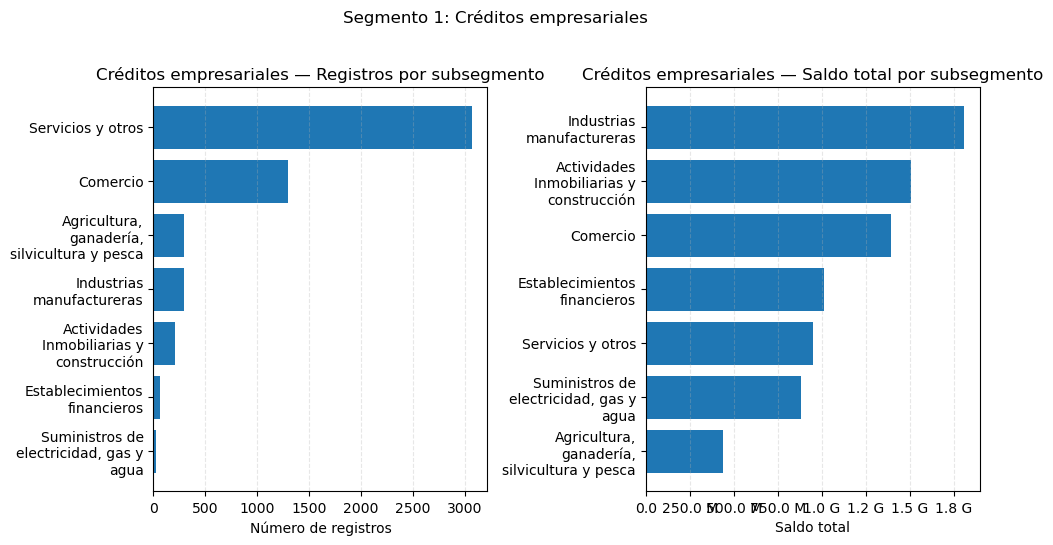

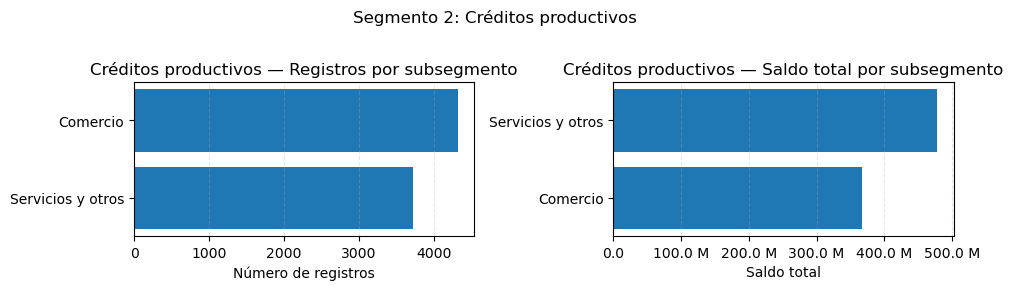

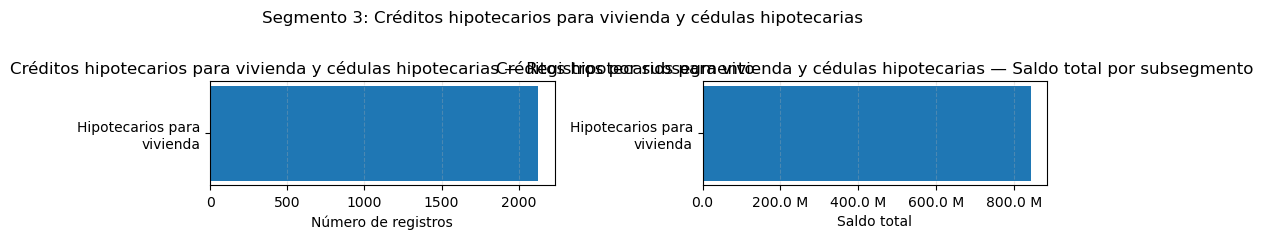

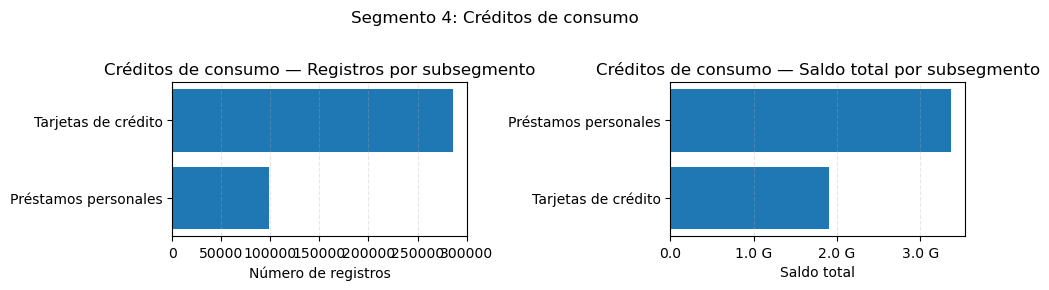

In [46]:
import textwrap
from matplotlib.ticker import EngFormatter

TOP_SUBSEGS = 8  # ya lo usabas arriba

def _wrap(s, width=22):
    return "\n".join(textwrap.wrap(str(s), width)) if isinstance(s, str) else s

def _collapse_top(series: pd.Series, top_k=TOP_SUBSEGS) -> pd.Series:
    series = series.copy().sort_values(ascending=False)
    if len(series) <= top_k:
        return series
    top = series.iloc[:top_k]
    return pd.concat([top, pd.Series({"Otros": series.iloc[top_k:].sum()})])

def plot_segment(segment_id: int, name: str):
    seg_df = dataset[dataset["id_segmento"] == segment_id]
    if seg_df.empty:
        print(f"(Segmento {segment_id} sin datos)")
        return

    counts = seg_df.groupby("subsegmento").size()
    counts = _collapse_top(counts, TOP_SUBSEGS)

    saldo = None
    if "saldo" in seg_df.columns:
        saldo = seg_df.groupby("subsegmento")["saldo"].sum(min_count=1).fillna(0)
        saldo = _collapse_top(saldo, TOP_SUBSEGS)

    # altura dinámica según cantidad de barras (labels legibles)
    n = len(counts)
    H = 0.5 * n + 1.8  # tuning fino
    fig, axes = plt.subplots(1, 2 if saldo is not None else 1, figsize=(10, H))
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    # --- Conteos (barh) ---
    y_pos = np.arange(len(counts))
    ax = axes[0]
    ax.barh(y_pos, counts.values)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([_wrap(x) for x in counts.index])
    ax.invert_yaxis()  # top primero
    ax.set_title(f"{name} — Registros por subsegmento")
    ax.set_xlabel("Número de registros")
    ax.grid(axis="x", linestyle="--", alpha=0.3)

    # --- Saldo (barh) ---
    if saldo is not None:
        y2 = np.arange(len(saldo))
        ax2 = axes[1]
        ax2.barh(y2, saldo.values)
        ax2.set_yticks(y2)
        ax2.set_yticklabels([_wrap(x) for x in saldo.index])
        ax2.invert_yaxis()
        ax2.set_title(f"{name} — Saldo total por subsegmento")
        ax2.set_xlabel("Saldo total")
        ax2.xaxis.set_major_formatter(EngFormatter(places=1))
        ax2.grid(axis="x", linestyle="--", alpha=0.3)

    fig.suptitle(f"Segmento {segment_id}: {name}", y=1.02)
    fig.tight_layout()
    plt.show()


# ---- Ejecutar para cada segmento (una figura por segmento) ----
for sid, sname in SEGMENTS.items():
    plot_segment(sid, sname)


### JAN 25

In [47]:
from pathlib import Path
import pandas as pd
from io import StringIO

# ---------------- CONFIG ----------------
CSV_PATH = Path("Data_Dummy/JAN25.csv")   # cámbialo por Data_Dummy/jan25.csv u otro
ENCODINGS = ["utf-8", "latin-1"]          # intentos de decodificación
SEGMENTS = {
    1: "Créditos empresariales",
    2: "Créditos productivos",
    3: "Créditos hipotecarios para vivienda y cédulas hipotecarias",
    4: "Créditos de consumo",
}

# --------- carga robusta (un solo dataset por archivo) ---------
assert CSV_PATH.exists(), f"No se encontró: {CSV_PATH.resolve()}"
for enc in ENCODINGS:
    try:
        dataset = pd.read_csv(CSV_PATH, encoding=enc, low_memory=False)
        break
    except UnicodeDecodeError:
        continue

# --------- df.info() ---------
buf = StringIO()
dataset.info(buf=buf)
print(f"Archivo: {CSV_PATH.name} | Filas: {len(dataset):,} | Columnas: {dataset.shape[1]}")
print(buf.getvalue())

# --------- resumen por segmento (si existen columnas) ---------
def _has(cols): return all(c in dataset.columns for c in cols)

if "id_segmento" in dataset.columns:
    # columnas opcionales
    has_subseg = "id_subsegmento" in dataset.columns
    has_saldo  = "saldo" in dataset.columns

    agg_dict = {"id_segmento": "size"}
    if has_subseg:
        agg_dict["id_subsegmento"] = pd.Series.nunique
    if has_saldo:
        agg_dict["saldo"] = "sum"

    resumen = (
        dataset.groupby("id_segmento", dropna=False)
               .agg(agg_dict)
               .rename(columns={
                   "id_segmento": "total_datos",
                   "id_subsegmento": "total_subsegmentos",
                   "saldo": "saldo_total"
               })
               .reset_index()
               .rename(columns={"id_segmento": "segmento"})
    )
    # descripción legible
    resumen["segmento_desc"] = resumen["segmento"].map(SEGMENTS)
    cols = ["segmento", "segmento_desc", "total_datos"]
    if "total_subsegmentos" in resumen.columns: cols.append("total_subsegmentos")
    if "saldo_total" in resumen.columns:        cols.append("saldo_total")
    resumen = resumen[cols]

    # mostrar tabla (funciona en .ipynb y en .py)
    try:
        from IPython.display import display
        print("\nResumen por segmento:")
        display(resumen)
    except Exception:
        print("\nResumen por segmento:")
        print(resumen.to_string(index=False))

# --------- totales del archivo ---------
total_subsegmentos = dataset["id_subsegmento"].nunique(dropna=True) if "id_subsegmento" in dataset.columns else 0
saldo_total = dataset["saldo"].sum(numeric_only=True) if "saldo" in dataset.columns else float("nan")
print(f"\nTotales del archivo -> Filas: {len(dataset):,}, "
      f"Subsegmentos únicos: {total_subsegmentos}, "
      f"Saldo total: {saldo_total:,.2f}")


Archivo: JAN25.csv | Filas: 400,000 | Columnas: 14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   mes                    400000 non-null  object 
 1   codigo_cuentahabiente  400000 non-null  object 
 2   nombre_cuentahabiente  400000 non-null  object 
 3   id_segmento            400000 non-null  int64  
 4   segmento               400000 non-null  object 
 5   id_subsegmento         400000 non-null  int64  
 6   subsegmento            400000 non-null  object 
 7   id_tipo_deudor         400000 non-null  int64  
 8   tipo_deudor            400000 non-null  object 
 9   id_situacion           400000 non-null  int64  
 10  situacion              400000 non-null  object 
 11  clasificacion          400000 non-null  object 
 12  score                  400000 non-null  int64  
 13  saldo                  400000 non-null

,segmento,segmento_desc,total_datos,total_subsegmentos,saldo_total
0,1,Créditos empresariales,12239,7,2.962451e+10
1,2,Créditos productivos,18834,2,1.393053e+09
2,3,Créditos hipotecarios para vivienda y cédulas ...,6872,2,1.116354e+09
3,4,Créditos de consumo,362055,3,7.411579e+09



Totales del archivo -> Filas: 400,000, Subsegmentos únicos: 14, Saldo total: 39,545,498,225.76


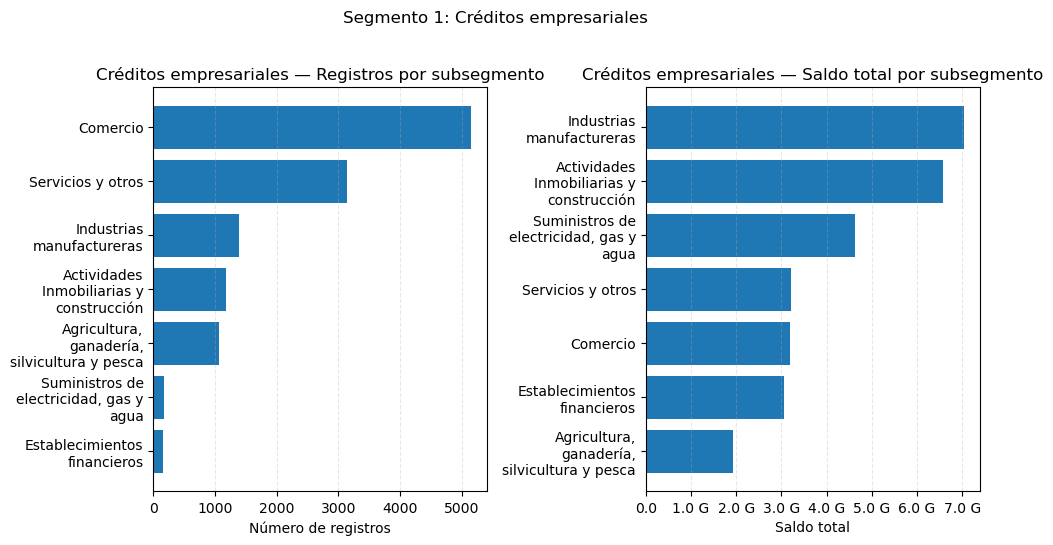

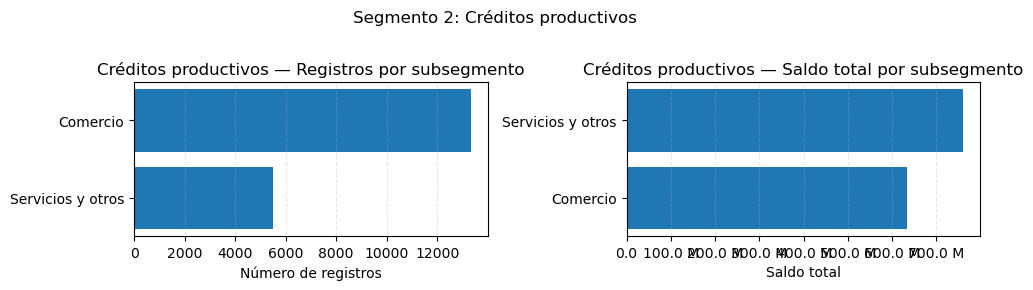

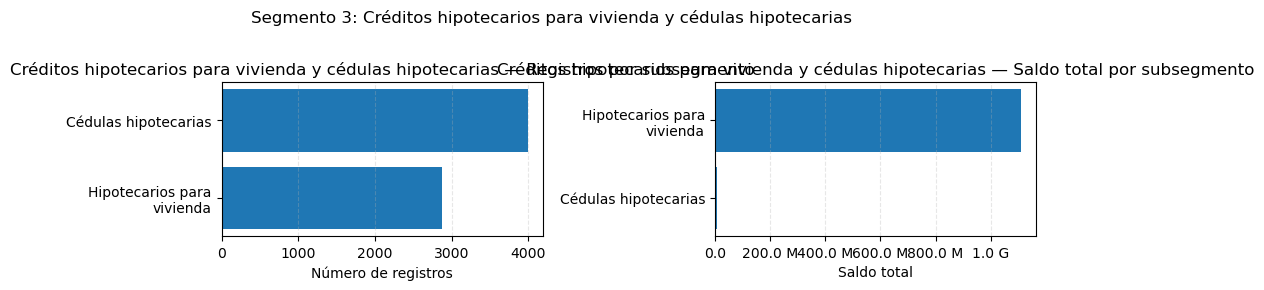

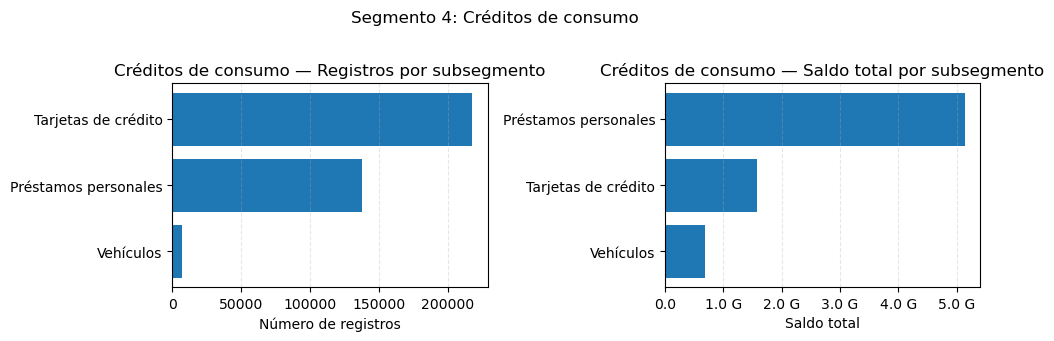

In [48]:
import textwrap
from matplotlib.ticker import EngFormatter

TOP_SUBSEGS = 8  # ya lo usabas arriba

def _wrap(s, width=22):
    return "\n".join(textwrap.wrap(str(s), width)) if isinstance(s, str) else s

def _collapse_top(series: pd.Series, top_k=TOP_SUBSEGS) -> pd.Series:
    series = series.copy().sort_values(ascending=False)
    if len(series) <= top_k:
        return series
    top = series.iloc[:top_k]
    return pd.concat([top, pd.Series({"Otros": series.iloc[top_k:].sum()})])

def plot_segment(segment_id: int, name: str):
    seg_df = dataset[dataset["id_segmento"] == segment_id]
    if seg_df.empty:
        print(f"(Segmento {segment_id} sin datos)")
        return

    counts = seg_df.groupby("subsegmento").size()
    counts = _collapse_top(counts, TOP_SUBSEGS)

    saldo = None
    if "saldo" in seg_df.columns:
        saldo = seg_df.groupby("subsegmento")["saldo"].sum(min_count=1).fillna(0)
        saldo = _collapse_top(saldo, TOP_SUBSEGS)

    # altura dinámica según cantidad de barras (labels legibles)
    n = len(counts)
    H = 0.5 * n + 1.8  # tuning fino
    fig, axes = plt.subplots(1, 2 if saldo is not None else 1, figsize=(10, H))
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    # --- Conteos (barh) ---
    y_pos = np.arange(len(counts))
    ax = axes[0]
    ax.barh(y_pos, counts.values)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([_wrap(x) for x in counts.index])
    ax.invert_yaxis()  # top primero
    ax.set_title(f"{name} — Registros por subsegmento")
    ax.set_xlabel("Número de registros")
    ax.grid(axis="x", linestyle="--", alpha=0.3)

    # --- Saldo (barh) ---
    if saldo is not None:
        y2 = np.arange(len(saldo))
        ax2 = axes[1]
        ax2.barh(y2, saldo.values)
        ax2.set_yticks(y2)
        ax2.set_yticklabels([_wrap(x) for x in saldo.index])
        ax2.invert_yaxis()
        ax2.set_title(f"{name} — Saldo total por subsegmento")
        ax2.set_xlabel("Saldo total")
        ax2.xaxis.set_major_formatter(EngFormatter(places=1))
        ax2.grid(axis="x", linestyle="--", alpha=0.3)

    fig.suptitle(f"Segmento {segment_id}: {name}", y=1.02)
    fig.tight_layout()
    plt.show()


# ---- Ejecutar para cada segmento (una figura por segmento) ----
for sid, sname in SEGMENTS.items():
    plot_segment(sid, sname)

### Registros totales JAN 24 Y JAN 25

#### JAN 24
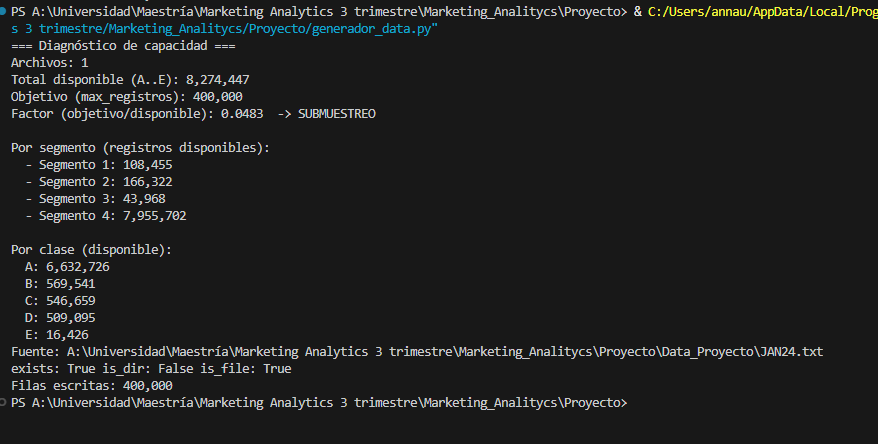

#### JAN 25

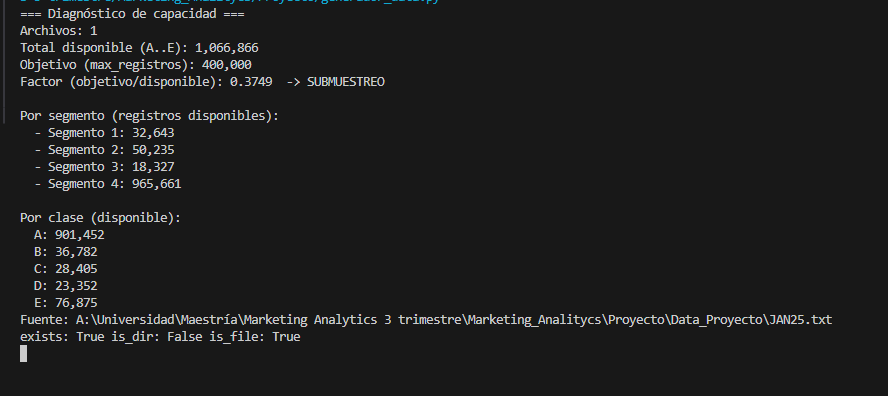